In [1]:
import random
import time
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from camel_tools.utils.normalize import normalize_unicode, normalize_alef_maksura_ar, normalize_alef_ar, normalize_teh_marbuta_ar
from camel_tools.utils.dediac import dediac_ar
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
# costume modules
from nexus_ai.sentence_sentiment_analysis.preprocessing import train_test_split


In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3070


In [3]:
df = pd.read_csv('dataset/ar_reviews_100k.tsv',sep='\t')
df.head()

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...


In [4]:
print(f'number of null values \n{df.isnull().sum()}')
print(f'number of duplicate values is {df.duplicated().sum()}')

number of null values 
label    0
text     0
dtype: int64
number of duplicate values is 0


In [5]:
labels = df['label'].unique()
print(f'labels {labels}')

labels ['Positive' 'Mixed' 'Negative']


let's drop Mixed

In [6]:
print(f'dataset shape before transforming: {df.shape}')

df.drop(df[df['label']=='Mixed'].index, axis=0, inplace=True)

print(f'dataset shape after transforming: {df.shape}')
labels = df['label'].unique()
print(f'labels {labels}')

dataset shape before transforming: (99999, 2)
dataset shape after transforming: (66666, 2)
labels ['Positive' 'Negative']


In [7]:
pos_prec = df[df['label'] == 'Positive'].shape[0]
neg_prec = df[df['label'] == 'Negative'].shape[0]
print(f'Positive precentage {pos_prec}')
print(f'Negative precentage {neg_prec}')

Positive precentage 33333
Negative precentage 33333


In [8]:
labels = df['label'].tolist()
encoded_labels = []
for label in labels:
    if label == 'Positive':
        encoded_labels.append(1)
    elif label == 'Negative':
        encoded_labels.append(0) 

unique, counts = np.unique(encoded_labels, return_counts=True)
distribution = dict(zip(unique, counts))
print('encoded_labels class distribution:')
for item in distribution.items():
    print(item)

encoded_labels class distribution:
(0, 33333)
(1, 33333)


In [9]:
# train_test_split is a costume function for balanced data you can view the details in the preprocessing module file 
train_x, validate_x, test_x, train_y, validate_y, test_y = train_test_split(df['text'].to_numpy(), encoded_labels, numclasses=2, train_frac=0.8, balanced=True)

make sure the classes (labels) are sorted to have a balanced splits


In [10]:
unique, counts = np.unique(train_y, return_counts=True)
distribution = dict(zip(unique, counts))
print('train_y class distribution:')
for item in distribution.items():
    print(item)

unique, counts = np.unique(validate_y, return_counts=True)
distribution = dict(zip(unique, counts))
print('validate_y class distribution:')
for item in distribution.items():
    print(item)

unique, counts = np.unique(test_y, return_counts=True)
distribution = dict(zip(unique, counts))
print('test_y class distribution:')
for item in distribution.items():
    print(item)

train_y class distribution:
(0, 26666)
(1, 26667)
validate_y class distribution:
(0, 3333)
(1, 3333)
test_y class distribution:
(0, 3333)
(1, 3333)


the dataset is balanced which is very good

now let's use the camel tools to preproccess the data

In [11]:
def text_preprocessing(text):
    
    text = normalize_unicode(text)
    # Normalizing alef variants to (ا)
    text = normalize_alef_ar(text)
    # Normalizing alef maksura (ى) to yeh (ي)
    text = normalize_alef_maksura_ar(text)
    # Normalizing teh marbuta (ة) to heh (ه)
    text = normalize_teh_marbuta_ar(text)
    # removing Arabic diacritical marks
    text = dediac_ar(text)
    
    return text

In [12]:
# Print sentence 0
print('Original: ', train_x[1])
print('Processed: ', text_preprocessing(train_x[1]))

Original:  أحد أسباب نجاح الإمارات أن كل شخص في هذه الدولة يعشق ترابها. نحن نحب الإمارات. ومضات من فكر. نصائح لدولة تطمح بالصفوف الأولى و قائد لا يقبل إلا براحة شعبه وتوفر كل سب العيش الكريم. حكم و مواقف ونصائح لكل فرد فينا ليس بمجرد كتاب سياسي كما كنت اعتقد. يستحق القراءة مرات كثيرة
Processed:  احد اسباب نجاح الامارات ان كل شخص في هذه الدوله يعشق ترابها. نحن نحب الامارات. ومضات من فكر. نصائح لدوله تطمح بالصفوف الاولي و قائد لا يقبل الا براحه شعبه وتوفر كل سب العيش الكريم. حكم و مواقف ونصائح لكل فرد فينا ليس بمجرد كتاب سياسي كما كنت اعتقد. يستحق القراءه مرات كثيره


In [13]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('CAMeL-Lab/bert-base-arabic-camelbert-msa')

In [14]:
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            truncation=True,
            max_length=MAX_LEN,             # Max length to truncate/pad
            padding='max_length',           # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [15]:
# Encode our concatenated data
encoded_reviews = [tokenizer.encode(review, add_special_tokens=True) for review in df['text'].to_numpy()]

# list contain each review length
reviews_lengths = [len(review) for review in encoded_reviews]
# Find the maximum length
max_len = max(reviews_lengths)
# Find the Avarage length
avg_len = sum(reviews_lengths) / len(reviews_lengths)

print(f'Max length: {max_len}')
print(f'Avarage length: {avg_len}')

Max length: 2675
Avarage length: 79.33831338313384


In [16]:
# Specify `MAX_LEN`
MAX_LEN = 128

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([train_x[0]])[0].squeeze().numpy())
attention_masks = list(preprocessing_for_bert([train_x[0]])[1].squeeze().numpy())
print('Original: ', train_x[0])
print('Token IDs: ', token_ids)
print('Attention Masks: ', attention_masks)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(train_x)
val_inputs, val_masks = preprocessing_for_bert(validate_x)

Original:  ممتاز نوعا ما . النظافة والموقع والتجهيز والشاطيء. المطعم
Token IDs:  [2, 9513, 15831, 1972, 18, 6418, 4484, 15999, 7752, 2421, 1008, 2861, 23141, 1053, 18, 20852, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention Masks:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


In [17]:
# Convert other data types to torch.Tensor
train_labels = torch.tensor(train_y)
val_labels = torch.tensor(validate_y)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [18]:
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False, bert_type='base'):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in = 768 if bert_type == 'base' else 1024
        H, D_out = 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('CAMeL-Lab/bert-base-arabic-camelbert-msa')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [19]:
def initialize_model(epochs=4, bert_type='base'):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False, bert_type=bert_type)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = torch.optim.AdamW(bert_classifier.parameters(),
                      lr=3e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [20]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)
            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels.long())
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")
    if evaluation == True:
        return val_accuracy


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels.long())
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [21]:
set_seed(12) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
val_accuracy = \
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-msa were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.597458   |     -      |     -     |   8.22   
   1    |   40    |   0.383035   |     -      |     -     |   5.01   
   1    |   60    |   0.370552   |     -      |     -     |   5.00   
   1    |   80    |   0.371699   |     -      |     -     |   5.01   
   1    |   100   |   0.333929   |     -      |     -     |   5.00   
   1    |   120   |   0.315233   |     -      |     -     |   5.01   
   1    |   140   |   0.319871   |     -      |     -     |   5.00   
   1    |   160   |   0.274725   |     -      |     -     |   5.01   
   1    |   180   |   0.334909   |     -      |     -     |   5.00   
   1    |   200   |   0.311759   |     -      |     -     |   5.00   
   1    |   220   |   0.290937   |     -      |     -     |   5.01   
   1    |   240   |   0.284972   |     -      |     -     |   5.01   


In [22]:
def bert_predict(model, test_dataloader):
    """
    Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [23]:
def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    return accuracy

AUC: 0.9701
Accuracy: 91.33%


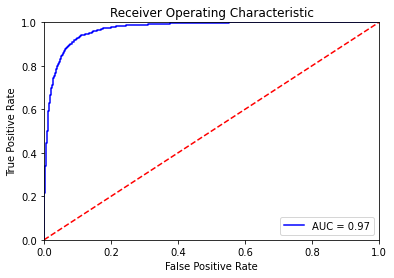

In [24]:
# Compute predicted probabilities on the validate set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
accuracy = evaluate_roc(probs, validate_y)

In [25]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_x)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


AUC: 0.9658
Accuracy: 90.40%


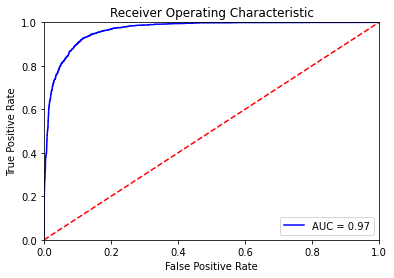

In [26]:
# Compute predicted probabilities on the validate set
probs = bert_predict(bert_classifier, test_dataloader)

# Evaluate the Bert classifier
accuracy = evaluate_roc(probs, test_y)

## train with merged train and validation sets

In [27]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(12)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-msa were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.606926   |     -      |     -     |   5.37   
   1    |   40    |   0.373628   |     -      |     -     |   4.89   
   1    |   60    |   0.369094   |     -      |     -     |   4.90   
   1    |   80    |   0.303436   |     -      |     -     |   4.90   
   1    |   100   |   0.348808   |     -      |     -     |   4.89   
   1    |   120   |   0.279536   |     -      |     -     |   4.89   
   1    |   140   |   0.303956   |     -      |     -     |   4.91   
   1    |   160   |   0.349730   |     -      |     -     |   4.91   
   1    |   180   |   0.301567   |     -      |     -     |   4.92   
   1    |   200   |   0.313989   |     -      |     -     |   4.94   
   1    |   220   |   0.278474   |     -      |     -     |   4.96   
   1    |   240   |   0.294514   |     -      |     -     |   4.97   


AUC: 0.9661
Accuracy: 90.50%


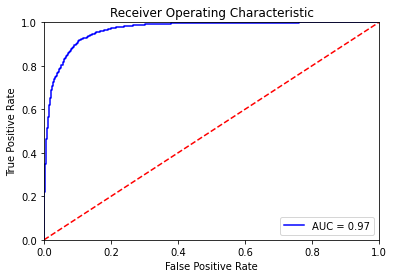

In [28]:
# Compute predicted probabilities on the validate set
probs = bert_predict(bert_classifier, test_dataloader)

# Evaluate the Bert classifier
accuracy = evaluate_roc(probs, test_y)

In [34]:
filename = f'models/binary_bert_arabic_01_acc_{accuracy*100:.2f}.pt'
# model_scripted = torch.jit.script(bert_classifier) # Export to TorchScript
torch.save(bert_classifier.state_dict(), filename)
# pickle.dump(bert_classifier, open(filename, 'wb'))

In [35]:
# Loading the model
filename = f'models/binary_bert_arabic_01_acc_{accuracy*100:.2f}.pt'
# bert_classifier = torch.load(filename, map_location='cpu')
bert_classifier.load_state_dict(torch.load(filename, map_location='cpu'))

<All keys matched successfully>

AUC: 0.9661
Accuracy: 90.50%


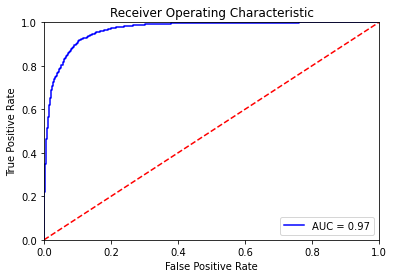

In [36]:
# Compute predicted probabilities on the validate set
probs = bert_predict(bert_classifier, test_dataloader)

# Evaluate the Bert classifier
accuracy = evaluate_roc(probs, test_y)

In [41]:
# save the BERT layer as a fine tuned BERT model  
filename = f'models/bert_pretrained_01_acc_{accuracy*100:.2f}'
bert_classifier.bert.save_pretrained(filename)